In [37]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

I first read the data obtained with the Keck telescope into the frame data

In [38]:
data = pd.read_table('Keckdata.txt', skiprows=[0, 2], sep='\s+')

I then select the 6 observations taken during the first intense series of observations

In [39]:
vals = (data['JD-2.44e6'] < 16856.0) & (data['JD-2.44e6']> 16845.0)
newdata = data[vals]
newdata

,Obnm,UTdate,JD-2.44e6,mnvel,errvel,mdchi,cts
4,rj189.1287,2014/07/10,16848.932372,-9.97,2.39,1.130,8240
5,rj189.1682,2014/07/12,16850.837724,-10.76,2.46,1.147,7866
6,rj189.1882,2014/07/13,16851.782552,-1.82,2.21,1.124,8194
7,rj189.2194,2014/07/15,16853.874880,-5.72,2.22,1.154,8775
8,rj189.2372,2014/07/16,16854.893017,-7.96,2.39,1.111,7600
9,rj189.2500,2014/07/17,16855.930215,-0.38,2.14,1.130,8422


And I select the three important variables, with the option to add an error in quadrature

In [40]:
bjd = np.array(newdata['JD-2.44e6'], 'd')
rvs = np.array(newdata['mnvel'], 'd')
rverr = np.array(newdata['errvel'], 'd')
additionalerr = 0.0
error = np.sqrt(rverr**2+additionalerr**2)

Now I use the orbital ephemeris obtained from the transits to define the orbital phases, and I also define a new zero point for the BJD timestamps

In [41]:
period = 0.6892099
tc = 2454953.1910
tc = tc-2440000.0

phasesaux = (bjd-tc)/period
phases, orbit = np.modf(phasesaux)

phases = phases
bjdlv = np.mean(bjd)
bjdrest, bjdint = np.modf(bjdlv)

phi0 = (bjdint-tc)/period
aux, phi0 = phi0-np.modf(phi0)

shortbjd = bjd-bjdint

data = np.append(phases, shortbjd)

Now I define a function to fit a simple second order polynomial with time with the planet signal

In [42]:
def parabolaplanet(x, K, a, b, c):
    "Model to fit a sinusoid to the RV data"
    num = len(x)
    newphase = x[0:num/2]
    newbjd = x[num/2:]
    return -K*np.sin(2.0*np.pi*newphase) + a + b*newbjd + c*newbjd**2

And I obtain the best fit parameters, their uncertainties, and I plot the observations and the model

In [43]:
params, conv = curve_fit(parabolaplanet, data, rvs, sigma=error )
paramserror = np.sqrt(np.diag(conv))


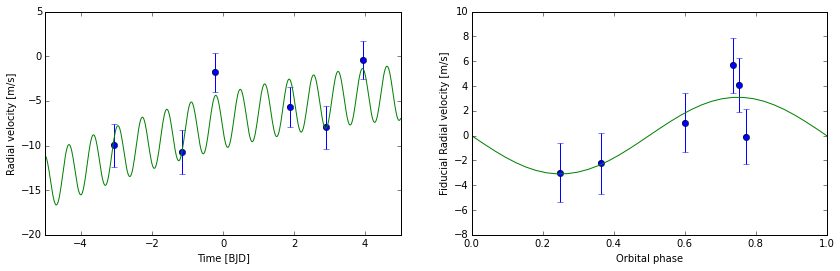

In [44]:
fig = plt.figure(figsize=(14,4))
ax = fig.add_subplot(1,2,1)
ax.scatter(shortbjd, rvs)
ax.errorbar(shortbjd, rvs, yerr=error, fmt='o')
plt.xlim([-5, 5]) 
ax.set_xlabel('Time [BJD]')
ax.set_ylabel('Radial velocity [m/s]')

K, a, b, c = params
Kerr, aerr, berr, cerr = paramserror
theoRV = parabolaplanet(data, K, a, b, c)
chi2= np.sum( ((theoRV-rvs)/error)**2)

newbjd = np.linspace(-5, 5, 500)
newx = (newbjd/period) + phi0

newdata = np.append(newx, newbjd)

plt.plot(newbjd, parabolaplanet(newdata, K, a, b, c))



ax = fig.add_subplot(1,2,2)

plottheoRV = parabolaplanet(data, 0.0, a, b, c)

ax.scatter(phases, rvs-plottheoRV)
ax.errorbar(phases, rvs-plottheoRV, yerr=error, fmt='o')
plt.xlim([-0, 1]) 
ax.set_xlabel('Orbital phase')
ax.set_ylabel('Fiducial Radial velocity [m/s]')

plt.plot(newx, parabolaplanet(newdata, K, 0.0, 0.0, 0.0))

In [48]:
print('K value {0:3.2f} +- {1:3.2f}' .format(K, Kerr))
print('Chi2 value {0:3.2f} with {1:1.0f} points and 5 parameters' .format(chi2, len(rvs)))

K value 3.09 +- 1.54
Chi2 value 3.69 with 6 points and 5 parameters
